<center><h1>Projet IA - Fake News & Deep Fake</h1></center>

<center><h1>Présenté par Shabboo ALEAGHA & Ophélie ENGASSER</h1></center>

<center><h2>M2-IADS-EL - Mai 2024</h2></center>

# Notebook #3. Transfer learning - BERT

Nous avons choisi de tester le modèle BERT selon une approche d'apprentissage par transfert, qui consiste à utiliser un modèle pré-entraîné et à l’adapter à une tâche cible en le ré-entraînant sur un corpus de données spécifique. Cette adaptation est possible grâce au fine-tuning du modèle. BERT est un modèle de pointe qui peut être utilisé dans de nombreuses applications de NLP (Mridha et al., 2021). Il intègre des représentations linguistiques pré-entraînées développées par Google et est construit sur une architecture codée par transformers. Il se distingue par sa capacité à identifier et capturer le sens contextuel dans un texte, et élimine les limitations habituellement liées à l’uni-directionnalité. Pour le fine-tuning, nous l’avons d’abord initialisé à partir de ‘bert-base-uncased’ avec les paramètres pré-entraînés, puis l’avons ré-entraîné à partir des données labellisées et adapté les paramètres à notre tâche, notamment en réglant plusieurs fois le learning rate.

In [ ]:
# connexion à Google Colab pour l'accès aux GPU
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importation des librairies

In [ ]:
!pip install transformers
!pip install torch
!pip install nltk
!pip install tqdm

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
nltk.download('stopwords')
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.nn import BatchNorm1d
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import StepLR
from torch import nn
import joblib
from sklearn.metrics import classification_report

# Préparation

In [ ]:
# récupération du df
df= pd.read_csv('/content/drive/Shareddrives/Projet IA M2 Fake News/Last fichiers/data_preprocessed.csv')
df.shape

<ipython-input-60-ea20129424e9>:2: DtypeWarning: Columns (5,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv('/content/drive/Shareddrives/Projet IA M2 Fake News/Last fichiers/data_preprocessed.csv')


(19423, 54)

In [ ]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.drop(columns=['index'], inplace=True)
df = df.dropna(subset=['preprocessed_text'])

In [ ]:
# préparation
X = list(df['preprocessed_text'])
y = list(df['type'])
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y = list(y_encoded)

In [ ]:
# split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split train-val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# affichage des tailles des ensembles
print("Taille de l'ensemble d'entraînement :", len(X_train))
print("Taille de l'ensemble de validation :", len(X_val))
print("Taille de l'ensemble de test :", len(X_test))

Taille de l'ensemble d'entraînement : 12382
Taille de l'ensemble de validation : 3096
Taille de l'ensemble de test : 3870


In [ ]:
# instanciation du tokenizer de BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# transformation en listes
texts_train = list(X_train)
texts_val = list(X_val)

max_length = 100

In [ ]:
# tokenization
tokenized_texts_train = tokenizer(texts_train, padding=True, truncation=True, return_tensors="pt", max_length=max_length)
tokenized_texts_val = tokenizer(texts_val, padding=True, truncation=True, return_tensors="pt", max_length=max_length)

In [ ]:
# conversion des labels en tensors
train_labels = torch.tensor(list(y_train), dtype=torch.long)
val_labels = torch.tensor(list(y_val), dtype=torch.long)

In [ ]:
# conversion des textes en tensors
train_dataset = TensorDataset(torch.tensor(tokenized_texts_train['input_ids']),
                              torch.tensor(tokenized_texts_train['attention_mask']),
                              torch.tensor(y_train))

val_dataset = TensorDataset(torch.tensor(tokenized_texts_val['input_ids']),
                            torch.tensor(tokenized_texts_val['attention_mask']),
                            torch.tensor(y_val))

<ipython-input-73-3345ff943c91>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(tokenized_texts_train['input_ids']),
<ipython-input-73-3345ff943c91>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(tokenized_texts_train['attention_mask']),
<ipython-input-73-3345ff943c91>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset = TensorDataset(torch.tensor(tokenized_texts_val['input_ids']),
<ipython-input-73-3345ff943c91>:6: UserWarning: To copy construct from a tensor, it is rec

In [ ]:
# création d'un modèle de classification de séquences avec l'architecture BERT pré-entraînée
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2, num_hidden_layers=12, hidden_size=768, output_attentions=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# configurations : optimizer, fonction de coût et scheduler
optimizer = AdamW([
    {'params': model.bert.parameters(), 'lr': 5e-6},
    {'params': model.classifier.parameters(), 'lr': 5e-6}
], lr=5e-6)
criterion = torch.nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# chargement des données en lots
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# configuration des epochs et du matériel
num_epochs = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# Entraînement

In [ ]:
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

In [ ]:
# boucle d'entraînement
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    tr_correct_preds = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        tr_loss = outputs.loss
        train_loss += tr_loss.item()
        tr_loss.backward()

        tr_logits = outputs.logits
        tr_preds = torch.argmax(tr_logits, dim=1)
        tr_correct_preds += torch.sum(tr_preds == labels).item()

        clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

    scheduler.step()

    # calcul de la perte moyenne d'entraînement pour chaque epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_accuracy = tr_correct_preds / len(X_train)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_preds = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            correct_preds += torch.sum(preds == labels).item()

    # calcul de la perte moyenne de validation pour chaque epoch
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_accuracy = correct_preds / len(X_val)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

Epoch 1/6, Validation Loss: 15.5311, Validation Accuracy: 0.8782, Training Loss: 96.2003, Training Accuracy: 0.7574
Epoch 2/6, Validation Loss: 14.8371, Validation Accuracy: 0.8828, Training Loss: 61.4232, Training Accuracy: 0.8755
Epoch 3/6, Validation Loss: 14.7192, Validation Accuracy: 0.8860, Training Loss: 59.2762, Training Accuracy: 0.8832
Epoch 4/6, Validation Loss: 14.7038, Validation Accuracy: 0.8860, Training Loss: 58.7822, Training Accuracy: 0.8833
Epoch 5/6, Validation Loss: 14.7038, Validation Accuracy: 0.8860, Training Loss: 58.9782, Training Accuracy: 0.8805
Epoch 6/6, Validation Loss: 14.7038, Validation Accuracy: 0.8860, Training Loss: 58.8029, Training Accuracy: 0.8830


# Evaluation

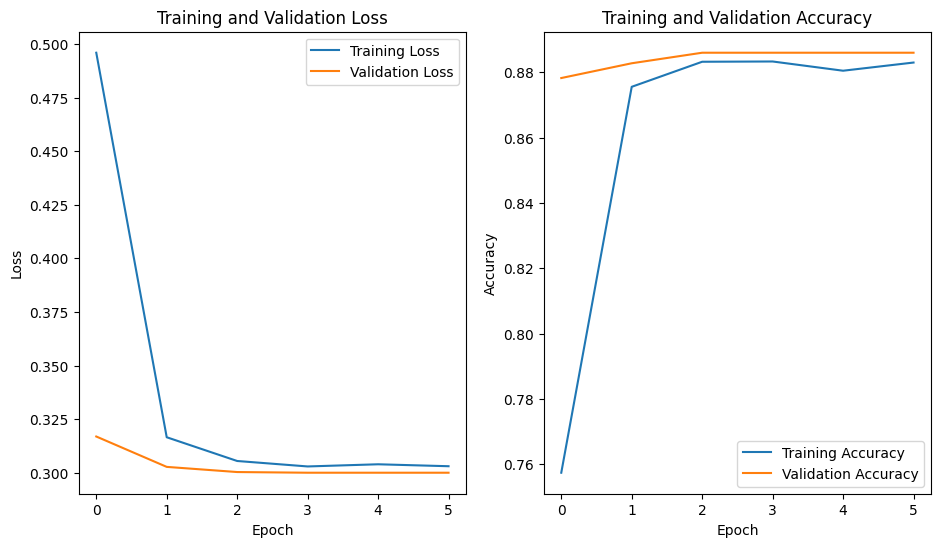

In [ ]:
plt.figure(figsize=(11,6))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

# Sauvegarde du modèle

In [ ]:
joblib.dump(model, 'model_bert.joblib')

['model_bert.joblib']

In [ ]:
loaded_model = joblib.load('model_bert.joblib')

# Test sur les données inédites

In [ ]:
# récupération des df scrapés
df_new_real = pd.read_csv('/content/drive/Shareddrives/Projet IA M2 Fake News/Last fichiers/data_new_real_time.csv', usecols=['articles'])
df_new_fake = pd.read_csv('/content/drive/Shareddrives/Projet IA M2 Fake News/Last fichiers/data_new_fake_theonion.csv', usecols=['articles'])

In [ ]:
# ajout d'une colonne de labels
df_new_fake['label'] = 0
df_new_real['label'] = 1

In [ ]:
# concaténation
df_new = pd.concat([df_new_fake, df_new_real], ignore_index=True)
df_new

,articles,label
0,"DAYTON, OH—While greeting the crowd at a campa...",0
1,Presidential candidate Donald Trump recently r...,0
2,And the RNC is going to pay for it. It probabl...,0
3,"VANDALIA, OH—Drawing criticism for what many c...",0
4,WASHINGTON—Her mind spinning as she poured ove...,0
...,...,...
3686,A Florida legislator has proposed banning most...,1
3687,When President Joe Biden stood in front of the...,1
3688,"This article is part of the The DC Brief, TIME...",1
3689,President Joe Biden’s remarks to the United Na...,1


In [ ]:
# rappel de la fonction pré-traitement linguistique
common_abbreviations = ["mr", "mrs", "ms", "dr", "etc"]

def preprocess_text(text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in string.punctuation]
    stop_words = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
    tokens = [word for word in tokens if not word.isdigit()]
    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(token) for token in tokens]
    tokens = [token for token in tokens if token.lower() not in common_abbreviations]
    tokens = [re.sub(r'\b[A-Za-z]\.', '', token) for token in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

In [ ]:
# pré-processing NLP avec la fonction préalablement implémentée
df_new['preprocessed_text'] = df_new['articles'].apply(preprocess_text)

In [ ]:
# préparation
X_new = df_new['preprocessed_text']
X_new

0       dayton oh greet crowd campaign ralli thursday ...
1       presidenti candid donald trump recent remark l...
2       rnc go pay probabl work worth shot week lara b...
3       vandalia oh draw critic mani call dehuman hurt...
4       washington mind spin pour sheaf paper vice pre...
                              ...                        
3686    florida legisl propos ban abort state allow la...
3687    presid joe biden stood front icon green marbl ...
3688    articl part dc brief time polit newslett sign ...
3689    presid joe biden remark unit nation general as...
3690    texa controversi six week abort banha effect d...
Name: preprocessed_text, Length: 3691, dtype: object

In [ ]:
y_new = df_new['label']
y_new

0       0
1       0
2       0
3       0
4       0
       ..
3686    1
3687    1
3688    1
3689    1
3690    1
Name: label, Length: 3691, dtype: int64

In [ ]:
# tokenization
def tokenize_dataset(dataset, tokenizer, max_length):
    tokenized_dataset = tokenizer(
        list(X_new),
        max_length=max_length,
        padding=True,
        truncation=True,
        return_tensors='pt'
    )
    return tokenized_dataset

In [ ]:
max_length = 100
X_new_tokenized = []
for text in X_new:
    encoded_input = tokenizer(text, max_length=max_length, padding='max_length', truncation=True, return_tensors='pt')
    X_new_tokenized.append(encoded_input)

In [ ]:
# prédictions
loaded_model.eval()
with torch.no_grad():
    pred_logits = []
    for batch in X_new_tokenized:
        input_ids, attention_mask = batch['input_ids'].to(device), batch['attention_mask'].to(device)
        outputs = loaded_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pred_logits.extend(logits.cpu().numpy())

# conversion des logits en probabilités avec une fonction softmax
pred_probs = torch.softmax(torch.tensor(pred_logits), dim=1).numpy()

# seuil
threshold = 0.5

# conversion des probabilités en classes binaires
pred_classes = np.where(pred_probs[:, 1] > threshold, 1, 0)

# classification report
report = classification_report(y_new, pred_classes, digits=5)
print(report)

              precision    recall  f1-score   support

           0    0.35241   0.13684   0.19714      1710
           1    0.51239   0.78294   0.61941      1981

    accuracy                        0.48361      3691
   macro avg    0.43240   0.45989   0.40827      3691
weighted avg    0.43827   0.48361   0.42377      3691



# Benchmark final de tous les modèles de Deep Learning

## Benchmark de l'accuracy train versus validation

In [2]:
# tableau comparatif de l'accuracy train versus validation de l'ensemble des modèles testés
df_final_eval_acc = pd.DataFrame({
    'Modèles': ['Simple embedding', 'Simple RNN', 'LSTM', 'BidirLSTM', 'BidirLSTM + CNN', 'w2v/BidirLSTM + CNN', 'BERT'],
    'Train accuracy': [.9826, .7803, .8387, .9668, .9972, .9460, .8830],
    'Validation accuracy': [.9442, .6233, .6426, .9359, .9127, .9270, .8860]
})
df_final_eval_acc

,Modèles,Train accuracy,Validation accuracy
0,Simple embedding,0.9826,0.9442
1,Simple RNN,0.7803,0.6233
2,LSTM,0.8387,0.6426
3,BidirLSTM,0.9668,0.9359
4,BidirLSTM + CNN,0.9972,0.9127
5,w2v/BidirLSTM + CNN,0.9460,0.9270
6,BERT,0.8830,0.8860


In [10]:
# graphique
df_melted = df_final_eval_acc.melt(id_vars='Modèles', var_name='Métrique', value_name='Valeur')
pio.templates.default = 'plotly_white'
fig = px.bar(df_melted, x='Modèles', y='Valeur', color='Métrique', barmode='group', text='Valeur',
             color_discrete_map={'Train accuracy': 'lightyellow', 'Validation accuracy': 'lightgrey'},
             title="Comparaison des performances sur l'ensemble des modèles testés",
             labels={'Modèles': 'Modèle', 'Valeur': 'Valeur'})
fig.update_layout(yaxis_showgrid=False, xaxis_tickangle=-45, xaxis_title='Modèle', yaxis_title='Valeur', yaxis_range=[0.49, 0.99], legend_title='Métrique')
fig.show()

Les modèles qui performent le mieux (seuil d’accuracy > .90), et présentent un bon compromis entre le train et la validation, ont été retenus pour être testés sur les données inédites.

## Benchmark des métriques sur les données inédites

In [11]:
# tableau comparatif des métriques des 5 modèles retenus sur l'ensemble inédit
df_final_eval_1 = pd.DataFrame({
    'Modèles finaux': ['Simple embedding', 'BidirLSTM', 'BidirLSTM + CNN', 'w2v/BidirLSTM + CNN', 'BERT'],
    'Accuracy': [.65809, .70685, .75535, .86291, .48361],
    'Précision': [.69097, .73649, .77517, .89082, .43827],
    'Recall': [.65809, .70685, .75353, .86291, .48361],
    'F1-Score': [.63066, .69022, .74690, .86191, .42377]
})
df_final_eval_1

,Modèles finaux,Accuracy,Précision,Recall,F1-Score
0,Simple embedding,0.65809,0.69097,0.65809,0.63066
1,BidirLSTM,0.70685,0.73649,0.70685,0.69022
2,BidirLSTM + CNN,0.75535,0.77517,0.75353,0.74690
3,w2v/BidirLSTM + CNN,0.86291,0.89082,0.86291,0.86191
4,BERT,0.48361,0.43827,0.48361,0.42377


In [18]:
# graphique
df_melted = df_final_eval_1.melt(id_vars='Modèles finaux', var_name='Métrique', value_name='Valeur')
pio.templates.default = 'plotly_white'
fig = px.bar(df_melted, x='Modèles finaux', y='Valeur', color='Métrique', barmode='group', text='Valeur',
             color_discrete_map={'Accuracy': 'lightyellow', 'Précision': 'lightgrey', 'Recall': 'grey', 'F1-Score': 'yellow'},
             title='Comparaison des performances des 5 modèles sur les données inédites',
             labels={'Modèles finaux': 'Modèle', 'Valeur': 'Valeur'})
fig.update_layout(yaxis_showgrid=False, xaxis_tickangle=-45, xaxis_title='Modèle final', yaxis_title='Valeur', yaxis_range=[0.26, 0.891], legend_title='Métrique')
fig.show()

Nous voyons une meilleure capacité du modèle combinant Word2Vec+BidirLSTM+CNN à généraliser sur les données inédites, avec un bon compromis entre la précision et le rappel.

## Métriques selon les classes

In [13]:
# données des métriques pour chaque modèle
data = {
    'Modèle': ['Simple embedding', 'BidirLSTM', 'BidirLSTM + CNN', 'w2v/BidirLSTM + CNN', 'BERT'],
    'Precision_0': [0.76603, 0.81781, 0.84695, 0.77514, 0.35241],
    'Recall_0': [0.37719, 0.47251, 0.57602, 0.99181, 0.13684],
    'F1-Score_0': [0.50549, 0.59896, 0.68569, 0.87019, 0.19714],
    'Precision_1': [0.62618, 0.66630, 0.71321, 0.99069, 0.51239],
    'Recall_1': [0.90056, 0.90914, 0.91015, 0.75164, 0.78294],
    'F1-Score_1': [0.73872, 0.76900, 0.79973, 0.85476, 0.61941],
}
df = pd.DataFrame(data)
df

,Modèle,Precision_0,Recall_0,F1-Score_0,Precision_1,Recall_1,F1-Score_1
0,Simple embedding,0.76603,0.37719,0.50549,0.62618,0.90056,0.73872
1,BidirLSTM,0.81781,0.47251,0.59896,0.66630,0.90914,0.76900
2,BidirLSTM + CNN,0.84695,0.57602,0.68569,0.71321,0.91015,0.79973
3,w2v/BidirLSTM + CNN,0.77514,0.99181,0.87019,0.99069,0.75164,0.85476
4,BERT,0.35241,0.13684,0.19714,0.51239,0.78294,0.61941


In [14]:
# graphique
trace_precision_0 = go.Scatter(x=df['Modèle'], y=df['Precision_0'], mode='lines+markers', name='Precision (Classe 0)', text=df['Precision_0'], textposition='top center')
trace_precision_1 = go.Scatter(x=df['Modèle'], y=df['Precision_1'], mode='lines+markers', name='Precision (Classe 1)', text=df['Precision_1'], textposition='top center')
trace_recall_0 = go.Scatter(x=df['Modèle'], y=df['Recall_0'], mode='lines+markers', name='Recall (Classe 0)', text=df['Recall_0'], textposition='top center')
trace_recall_1 = go.Scatter(x=df['Modèle'], y=df['Recall_1'], mode='lines+markers', name='Recall (Classe 1)', text=df['Recall_1'], textposition='top center')
trace_f1_score_0 = go.Scatter(x=df['Modèle'], y=df['F1-Score_0'], mode='lines+markers', name='F1-Score (Classe 0)', text=df['F1-Score_0'], textposition='top center')
trace_f1_score_1 = go.Scatter(x=df['Modèle'], y=df['F1-Score_1'], mode='lines+markers', name='F1-Score (Classe 1)', text=df['F1-Score_1'], textposition='top center')

fig = make_subplots(rows=3, cols=1, subplot_titles=("Précision", "Rappel", "F1-Score"))

fig.add_trace(go.Scatter(x=df['Modèle'], y=df['Precision_0'], mode='lines+markers', name='Precision (Classe 0)', text=df['Precision_0'], textposition='top center'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['Modèle'], y=df['Precision_1'], mode='lines+markers', name='Precision (Classe 1)', text=df['Precision_1'], textposition='top center'), row=1, col=1)

# ajout des étiquettes et des lignes
for i, (x, y) in enumerate(zip(df['Modèle'], df['Precision_0'])):
    fig.add_annotation(x=x, y=y + 0.04, text=str(df['Precision_0'][i].round(2)), showarrow=False, row=1, col=1)

for i, (x, y) in enumerate(zip(df['Modèle'], df['Precision_1'])):
    fig.add_annotation(x=x, y=y + 0.04, text=str(df['Precision_1'][i].round(2)), showarrow=False, row=1, col=1)

fig.add_trace(go.Scatter(x=df['Modèle'], y=df['Recall_0'], mode='lines+markers', name='Recall (Classe 0)', text=df['Recall_0'], textposition='top center'), row=2, col=1)
fig.add_trace(go.Scatter(x=df['Modèle'], y=df['Recall_1'], mode='lines+markers', name='Recall (Classe 1)', text=df['Recall_1'], textposition='top center'), row=2, col=1)

for i, (x, y) in enumerate(zip(df['Modèle'], df['Recall_0'])):
    fig.add_annotation(x=x, y=y + 0.04, text=str(df['Recall_0'][i].round(2)), showarrow=False, row=2, col=1)

for i, (x, y) in enumerate(zip(df['Modèle'], df['Recall_1'])):
    fig.add_annotation(x=x, y=y + 0.04, text=str(df['Recall_1'][i].round(2)), showarrow=False, row=2, col=1)

fig.add_trace(go.Scatter(x=df['Modèle'], y=df['F1-Score_0'], mode='lines+markers', name='F1-Score (Classe 0)', text=df['F1-Score_0'], textposition='top center'), row=3, col=1)
fig.add_trace(go.Scatter(x=df['Modèle'], y=df['F1-Score_1'], mode='lines+markers', name='F1-Score (Classe 1)', text=df['F1-Score_1'], textposition='top center'), row=3, col=1)

for i, (x, y) in enumerate(zip(df['Modèle'], df['F1-Score_0'])):
    fig.add_annotation(x=x, y=y + 0.04, text=str(df['F1-Score_0'][i].round(2)), showarrow=False, row=3, col=1)

for i, (x, y) in enumerate(zip(df['Modèle'], df['F1-Score_1'])):
    fig.add_annotation(x=x, y=y + 0.04, text=str(df['F1-Score_1'][i].round(2)), showarrow=False, row=3, col=1)

fig.update_layout(title='Métriques de test sur données inédites par classe', width=1000, height=800, plot_bgcolor='rgba(0,0,0,0)')
fig.show()

Il est intéressant de constater à partir des métriques par classe sur les données inédites les tendances qui se dessinent entre les modèles concernant les capacités à prédire certaines classes. Concernant la précision pour les 3 premiers modèles (simple embedding, BidirLSTM et BidirLSTM+CNN), on constate de meilleures performances pour la prédiction de fake, parmi tous les articles que les modèles ont prédit. Pour le rappel, parmi tous les articles réellement étiquetés de chaque classe, les modèles prédisent mieux les real, la différence entre les deux classes étant plus accentuée pour le simple embedding et le BidirLSTM que pour le BidirLSTM+CNN. Les F1-Scores des classes 0 sont plus faibles pour les 3 premiers modèles, l’écart entre les classes diminuant avec BidirLSTM et BidirLSTM+CNN, suggérant une amélioration des performances à mesure de la complexité de l’architecture des réseaux.
Nous observons un pattern inverse pour le modèle w2v/BidirLSTM+CNN. La précision est meilleure pour la classe 1 que pour la classe 0, et inversement pour le rappel. Ces scores engendrent un F1-Score très acceptable pour les deux classes, révélant la qualité globale de ce modèle et sa capacité de prédiction de chacune des classes. 
Le modèle pré-entraîné BERT rejoint le pattern des trois premiers pour le rappel et le F1-Score, mais présente une précision plus forte pour la classe 1, suggérant qu’il prédit et rappelle mieux les real, et n’est pas en capacité d’être compétent sur les fake.


Pour résumer, l’ensemble des résultats est en faveur d’une supériorité du modèle combinant une architecture LSTM bidirectionnelle avec une couche de convolution CNN, utilisant en entrée des embeddings de mots Word2Vec. Il affiche de très bonnes performances sur toutes les métriques, avec une bonne précision et un bon rappel, ce qui indique qu’il identifie correctement les nouveaux articles, quelles que soient leurs classes. Ce comportement offre un bon compromis entre faux positifs et faux négatifs, qui pourrait rendre ce modèle apte à être utilisé en production. Ces éléments nous apprennent que l’augmentation en complexité dans l’architecture des modèles a été en mesure de répondre à la tâche de classification de fake news, permettant de capturer plus de complexité et de caractéristiques intrinsèques dans les données textuelles même inédites. Cela est d’autant plus visible lorsque les modèles tirent profit de la combinaison de deux architectures efficaces et complémentaires telles que RNN - pour la prise en compte de l’aspect séquentiel du langage et une prise de recul sur la globalité, avec une extension LSTM conservant en mémoire les informations importantes même sur des séquences longues, et CNN - pour une extraction des caractéristiques locales des textes, et que les embeddings d’entrée sont issus d’un modèle pré-implémenté comme Word2Vec. Il apparaît également dans les résultats que certains classifieurs de Machine Learning dits “traditionnels” performent mieux que les réseaux de neurones les plus simples que nous avons testés, ce qui confirme certaines observations déjà évoquées (Khan et al., 2019).

# Discussion générale sur les modèles d'apprentissage profond

Dans la partie dédiée aux modèles de Deep Learning, nous avons testé différentes architectures, en partant de la plus simple pour aller vers la plus complexe, et en optimisant les modèles par ajustement des hyperparamètres. Parmi les modèles retenus (c’est-à-dire affichant la meilleure accuracy lors de l’entraînement), nous avons mis en évidence que plus l’architecture des réseaux était complexe, plus ces derniers étaient en mesure d’augmenter leurs métriques lors des tests sur des données jamais rencontrées. D’après les graphiques montrant les performances lors du test et sur données inédites, on voit que les résultats à ces deux étapes ne sont pas forcément corrélés. Les meilleures promesses de généralisation proviennent, comme on l’a vu, des architectures plus complexes. Nos résultats valident l’efficacité déjà démontrée des RNN et CNN, ceux-ci étant parmi les plus utilisés dans la détection de fake news (Mridha et al., 2021). Les résultats vont également dans le sens de Fernandez-Reyes & Shinde (2018) pour qui ces deux types de réseaux sont les plus intéressants dans le domaine des fake news politiques. Les auteurs évoquent même une popularité grandissante des CNN pour des tâches de NLP, offrant leurs atouts dans la recherche des caractéristiques locales. Dans notre travail, nous les avons combinés, afin d’obtenir la meilleure expérience des deux, en utilisant aussi l'extension LSTM des RNN, en plus d’une alimentation du réseau avec les embeddings de mots obtenus par le Word2Vec. Nous constatons indéniablement que ce réseau a permis plus que les autres de capturer le langage dans son aspect contextuel et sémantique, et ce de manière plus fine que ne l’a fait BERT, réputé généralement pour être à la pointe dans ce type de cas d’usage. Certains auteurs font le même constat : une supériorité de l’intégration Word2Vec - LSTM pour la détection de fake news, comparativement à des modèles d’apprentissage traditionnels ou un BERT (Mallik & Kumar, 2023). Adrian, Prasetyowati & Sibaroni (2023) montrent également de meilleures performances d’une intégration Word2Vec - LSTM pour la même tâche, par rapport à une intégration GloVe - LSTM, avec une précision moyenne de 95% et 90% respectivement. Selon les auteurs, Word2Vec pourrait mieux capturer les relations sémantiques entre les mots, tandis que GloVe serait plus à même de relever les relations de distribution et la cooccurrence des mots. Notre travail nous amène à nous dire que dans le cas d’usage de la détection des fake news, un accent mis sur la sémantique dans la construction d’un modèle, serait une stratégie payante. C’est cette stratégie que nous avons accentuée dans ce projet, misant comme nous l’avons dit, sur un nettoyage de tout bruit permettant éventuellement aux modèles de se baser sur autre chose que la sémantique. L’utilisation de données inédites issues d’un journal satirique écrit dans le même style journalistique qu’un article vrai, renforce la confiance que nous pouvons avoir dans les capacités de généralisation du modèle “gagnant”.
